In [7]:
import torch
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from DatasetFetcher import DatasetFetcher
from project1_model import *

In [8]:
# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# Fetching Dataset
df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
df.addHorizontalFlipping()
#df.addVerticalFlipping()
df.addRandomCrop(size=32, padding=4)
#df.addAutoAugmentation()
#df.addHistogramEqualization()
df.addNormalizer()
#df.addGaussianNoise()
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Get Model
#model = ResNet(BasicBlock, 32, 4, [4, 4, 4, 2], 10, bias=True)
model = project1_model()
model = model.to(device)
print(summary(model, input_size=(3, 32, 32)))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  9,248
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,248
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  9,248
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  9,248
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Sequential: 3-10             --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 9,248
|    |    └─BatchNorm2d: 3-12            64
|    |    └─Conv2d: 3-13                 9,248
|    |    └─BatchNorm2d: 3-14            64
|    |    └─Sequential: 3-15             --
|    └─B

In [11]:
# Setting up training
EPOCHS=300
globalBestAccuracy = 0.0
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [12]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer) 
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.1
weightDecay = 0.0001
#optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learningRate, weight_decay=weightDecay)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [13]:
# Training
for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model.train()
            optimizer.zero_grad()
        else:
            loader = testLoader
            model.eval()
        runningLoss = 0.0
        runningCorrects = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = lossFunction(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            #runningLoss += loss.item()*images.size(0)
            runningLoss += loss.item()
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))

  0%|          | 1/300 [00:29<2:25:38, 29.23s/it]

Training Loss : 1.7354650946044923, Testing Loss : 1.6677862905502319, Training Accuracy : 0.35232, Testing Accuracy : 0.393


  1%|          | 2/300 [00:55<2:17:39, 27.72s/it]

Training Loss : 1.4831534854125976, Testing Loss : 1.47858519115448, Training Accuracy : 0.44848, Testing Accuracy : 0.4718


  1%|          | 3/300 [01:22<2:14:42, 27.21s/it]

Training Loss : 1.312076495513916, Testing Loss : 1.3043260232925415, Training Accuracy : 0.52412, Testing Accuracy : 0.533


  1%|▏         | 4/300 [01:48<2:12:49, 26.92s/it]

Training Loss : 1.2217908613586426, Testing Loss : 1.2176563386917114, Training Accuracy : 0.55962, Testing Accuracy : 0.5658


  2%|▏         | 5/300 [02:15<2:11:46, 26.80s/it]

Training Loss : 1.1010410765075684, Testing Loss : 1.0394388681411744, Training Accuracy : 0.60674, Testing Accuracy : 0.636


  2%|▏         | 6/300 [02:42<2:10:45, 26.69s/it]

Training Loss : 0.9722212400817871, Testing Loss : 1.00440032787323, Training Accuracy : 0.65418, Testing Accuracy : 0.654


  2%|▏         | 7/300 [03:08<2:10:00, 26.62s/it]

Training Loss : 0.914807995300293, Testing Loss : 0.9623118154525757, Training Accuracy : 0.67758, Testing Accuracy : 0.6732


  3%|▎         | 8/300 [03:35<2:09:24, 26.59s/it]

Training Loss : 0.8450512214660645, Testing Loss : 0.8724887259483337, Training Accuracy : 0.7014, Testing Accuracy : 0.6959


  3%|▎         | 9/300 [04:01<2:08:51, 26.57s/it]

Training Loss : 0.7801914462280274, Testing Loss : 0.8780168292999267, Training Accuracy : 0.72528, Testing Accuracy : 0.7075


  3%|▎         | 10/300 [04:28<2:08:13, 26.53s/it]

Training Loss : 0.7211723003387451, Testing Loss : 0.7582324287414551, Training Accuracy : 0.74642, Testing Accuracy : 0.7378


  4%|▎         | 11/300 [04:54<2:07:51, 26.55s/it]

Training Loss : 0.6679014626312256, Testing Loss : 0.7260411559104919, Training Accuracy : 0.7676, Testing Accuracy : 0.7497


  4%|▍         | 12/300 [05:20<2:07:13, 26.50s/it]

Training Loss : 0.6447981188201904, Testing Loss : 0.7644953764915466, Training Accuracy : 0.77502, Testing Accuracy : 0.7384


  4%|▍         | 13/300 [05:47<2:06:44, 26.50s/it]

Training Loss : 0.6080448766326905, Testing Loss : 0.6604789435386658, Training Accuracy : 0.7895, Testing Accuracy : 0.7768


  5%|▍         | 14/300 [06:14<2:06:26, 26.53s/it]

Training Loss : 0.5659197882080078, Testing Loss : 0.6282076209068298, Training Accuracy : 0.8031, Testing Accuracy : 0.7898


  5%|▌         | 15/300 [06:40<2:05:56, 26.51s/it]

Training Loss : 0.5409508362579346, Testing Loss : 0.6003943267822266, Training Accuracy : 0.81328, Testing Accuracy : 0.8005


  5%|▌         | 16/300 [07:07<2:05:34, 26.53s/it]

Training Loss : 0.5076291076660157, Testing Loss : 0.5763287132263184, Training Accuracy : 0.8237, Testing Accuracy : 0.8031


  6%|▌         | 17/300 [07:33<2:05:05, 26.52s/it]

Training Loss : 0.49909190551757815, Testing Loss : 0.5609957662582398, Training Accuracy : 0.82836, Testing Accuracy : 0.8094


  6%|▌         | 18/300 [08:00<2:04:30, 26.49s/it]

Training Loss : 0.4664493359375, Testing Loss : 0.5611724758148193, Training Accuracy : 0.83918, Testing Accuracy : 0.813


  6%|▋         | 19/300 [08:26<2:04:04, 26.49s/it]

Training Loss : 0.44293606693267823, Testing Loss : 0.5675758053302765, Training Accuracy : 0.84732, Testing Accuracy : 0.8087


  7%|▋         | 20/300 [08:53<2:03:45, 26.52s/it]

Training Loss : 0.43095991355895996, Testing Loss : 0.5093190719604492, Training Accuracy : 0.85186, Testing Accuracy : 0.8246


  7%|▋         | 21/300 [09:19<2:03:16, 26.51s/it]

Training Loss : 0.4190491223907471, Testing Loss : 0.5092769483566284, Training Accuracy : 0.85572, Testing Accuracy : 0.8277


  7%|▋         | 22/300 [09:46<2:02:43, 26.49s/it]

Training Loss : 0.41421456569671633, Testing Loss : 0.5006771307945251, Training Accuracy : 0.85736, Testing Accuracy : 0.8272


  8%|▊         | 23/300 [10:12<2:02:34, 26.55s/it]

Training Loss : 0.3869324253082275, Testing Loss : 0.4657096116542816, Training Accuracy : 0.86708, Testing Accuracy : 0.845


  8%|▊         | 24/300 [10:39<2:02:03, 26.54s/it]

Training Loss : 0.36716716075897216, Testing Loss : 0.5051701766967773, Training Accuracy : 0.8731, Testing Accuracy : 0.8347


  8%|▊         | 25/300 [11:05<2:01:33, 26.52s/it]

Training Loss : 0.35236793991088866, Testing Loss : 0.48766777415275575, Training Accuracy : 0.87806, Testing Accuracy : 0.8451


  9%|▊         | 26/300 [11:32<2:01:04, 26.51s/it]

Training Loss : 0.34292702178955076, Testing Loss : 0.4806460161209106, Training Accuracy : 0.88044, Testing Accuracy : 0.8375


  9%|▉         | 27/300 [11:58<2:00:31, 26.49s/it]

Training Loss : 0.34437659282684324, Testing Loss : 0.4793152594566345, Training Accuracy : 0.88036, Testing Accuracy : 0.8444


  9%|▉         | 28/300 [12:25<2:00:04, 26.49s/it]

Training Loss : 0.34054229372024536, Testing Loss : 0.43603378343582155, Training Accuracy : 0.88416, Testing Accuracy : 0.852


 10%|▉         | 29/300 [12:51<1:59:29, 26.46s/it]

Training Loss : 0.3208587780380249, Testing Loss : 0.461348725438118, Training Accuracy : 0.8903, Testing Accuracy : 0.8485


 10%|█         | 30/300 [13:17<1:59:02, 26.45s/it]

Training Loss : 0.3102255757141113, Testing Loss : 0.44235850377082825, Training Accuracy : 0.89332, Testing Accuracy : 0.8503


 10%|█         | 31/300 [13:44<1:58:31, 26.44s/it]

Training Loss : 0.30489403539657595, Testing Loss : 0.45996403245925904, Training Accuracy : 0.894, Testing Accuracy : 0.8475


 11%|█         | 32/300 [14:10<1:58:10, 26.46s/it]

Training Loss : 0.29165974248886106, Testing Loss : 0.43503959808349607, Training Accuracy : 0.89938, Testing Accuracy : 0.8584


 11%|█         | 33/300 [14:37<1:57:43, 26.46s/it]

Training Loss : 0.2816079810142517, Testing Loss : 0.43395520877838134, Training Accuracy : 0.90264, Testing Accuracy : 0.8559


 11%|█▏        | 34/300 [15:03<1:57:18, 26.46s/it]

Training Loss : 0.275523699760437, Testing Loss : 0.431618906211853, Training Accuracy : 0.90562, Testing Accuracy : 0.863


 12%|█▏        | 35/300 [15:30<1:56:51, 26.46s/it]

Training Loss : 0.2744520178413391, Testing Loss : 0.4183151422023773, Training Accuracy : 0.90454, Testing Accuracy : 0.8622


 12%|█▏        | 36/300 [15:56<1:56:26, 26.46s/it]

Training Loss : 0.26355659452438357, Testing Loss : 0.4052179075241089, Training Accuracy : 0.90928, Testing Accuracy : 0.8641


 12%|█▏        | 37/300 [16:23<1:56:02, 26.47s/it]

Training Loss : 0.2525545364379883, Testing Loss : 0.42433010835647583, Training Accuracy : 0.91238, Testing Accuracy : 0.8626


 13%|█▎        | 38/300 [16:49<1:55:38, 26.48s/it]

Training Loss : 0.24803892612457276, Testing Loss : 0.42778396258354184, Training Accuracy : 0.91354, Testing Accuracy : 0.862


 13%|█▎        | 39/300 [17:16<1:55:12, 26.48s/it]

Training Loss : 0.23794193021774293, Testing Loss : 0.42375502185821534, Training Accuracy : 0.91732, Testing Accuracy : 0.8677


 13%|█▎        | 40/300 [17:42<1:54:52, 26.51s/it]

Training Loss : 0.23093849140167236, Testing Loss : 0.41816884129047394, Training Accuracy : 0.9194, Testing Accuracy : 0.8658


 14%|█▎        | 41/300 [18:09<1:54:25, 26.51s/it]

Training Loss : 0.22876076137542725, Testing Loss : 0.4295346945762634, Training Accuracy : 0.9209, Testing Accuracy : 0.8691


 14%|█▍        | 42/300 [18:35<1:54:08, 26.54s/it]

Training Loss : 0.2237055068397522, Testing Loss : 0.42415211820602416, Training Accuracy : 0.92226, Testing Accuracy : 0.8702


 14%|█▍        | 43/300 [19:02<1:53:32, 26.51s/it]

Training Loss : 0.22329865324020387, Testing Loss : 0.45066541090011597, Training Accuracy : 0.92244, Testing Accuracy : 0.8643


 15%|█▍        | 44/300 [19:28<1:53:07, 26.51s/it]

Training Loss : 0.213433334608078, Testing Loss : 0.43925020327568054, Training Accuracy : 0.92536, Testing Accuracy : 0.8667


 15%|█▌        | 45/300 [19:55<1:52:46, 26.54s/it]

Training Loss : 0.2050458398914337, Testing Loss : 0.4052956090927124, Training Accuracy : 0.92816, Testing Accuracy : 0.873


 15%|█▌        | 46/300 [20:22<1:52:23, 26.55s/it]

Training Loss : 0.19356764547348024, Testing Loss : 0.41457256984710694, Training Accuracy : 0.9321, Testing Accuracy : 0.88


 16%|█▌        | 47/300 [20:48<1:51:53, 26.54s/it]

Training Loss : 0.1925943563079834, Testing Loss : 0.4307814979553223, Training Accuracy : 0.93248, Testing Accuracy : 0.8701


 16%|█▌        | 48/300 [21:15<1:51:23, 26.52s/it]

Training Loss : 0.19235578795433045, Testing Loss : 0.4727604955673218, Training Accuracy : 0.934, Testing Accuracy : 0.8664


 16%|█▋        | 49/300 [21:41<1:50:48, 26.49s/it]

Training Loss : 0.1956341423034668, Testing Loss : 0.40379793127775193, Training Accuracy : 0.933, Testing Accuracy : 0.8751


 17%|█▋        | 50/300 [22:07<1:50:22, 26.49s/it]

Training Loss : 0.18654917408943175, Testing Loss : 0.4298017903327942, Training Accuracy : 0.9338, Testing Accuracy : 0.8783


 17%|█▋        | 51/300 [22:34<1:49:48, 26.46s/it]

Training Loss : 0.17626884107589721, Testing Loss : 0.42424368834495546, Training Accuracy : 0.93726, Testing Accuracy : 0.8756


 17%|█▋        | 52/300 [23:00<1:49:16, 26.44s/it]

Training Loss : 0.17915985591888428, Testing Loss : 0.4234448751449585, Training Accuracy : 0.93766, Testing Accuracy : 0.877


 18%|█▊        | 53/300 [23:27<1:48:53, 26.45s/it]

Training Loss : 0.18452846446990967, Testing Loss : 0.397722958278656, Training Accuracy : 0.93572, Testing Accuracy : 0.8844


 18%|█▊        | 54/300 [23:53<1:48:28, 26.46s/it]

Training Loss : 0.17038069951057433, Testing Loss : 0.3802052976608276, Training Accuracy : 0.94126, Testing Accuracy : 0.8892


 18%|█▊        | 55/300 [24:20<1:47:54, 26.43s/it]

Training Loss : 0.15770492346763612, Testing Loss : 0.42708043489456177, Training Accuracy : 0.9461, Testing Accuracy : 0.8792


 19%|█▊        | 56/300 [24:46<1:47:33, 26.45s/it]

Training Loss : 0.15142023676872254, Testing Loss : 0.41822508788108825, Training Accuracy : 0.94696, Testing Accuracy : 0.8901


 19%|█▉        | 57/300 [25:13<1:47:13, 26.48s/it]

Training Loss : 0.15472997437477112, Testing Loss : 0.3900460672855377, Training Accuracy : 0.9458, Testing Accuracy : 0.8849


 19%|█▉        | 58/300 [25:39<1:46:43, 26.46s/it]

Training Loss : 0.1526310195350647, Testing Loss : 0.40890002994537356, Training Accuracy : 0.94594, Testing Accuracy : 0.8878


 20%|█▉        | 59/300 [26:05<1:46:20, 26.47s/it]

Training Loss : 0.14524435134887695, Testing Loss : 0.4433163928747177, Training Accuracy : 0.94994, Testing Accuracy : 0.8869


 20%|██        | 60/300 [26:32<1:45:47, 26.45s/it]

Training Loss : 0.14589664883613587, Testing Loss : 0.3892867431640625, Training Accuracy : 0.9484, Testing Accuracy : 0.8877


 20%|██        | 61/300 [26:58<1:45:28, 26.48s/it]

Training Loss : 0.13677586232185363, Testing Loss : 0.4469616067886353, Training Accuracy : 0.95304, Testing Accuracy : 0.8842


 21%|██        | 62/300 [27:25<1:44:57, 26.46s/it]

Training Loss : 0.14045341110229492, Testing Loss : 0.39729260816574097, Training Accuracy : 0.95092, Testing Accuracy : 0.8844


 21%|██        | 63/300 [27:51<1:44:29, 26.46s/it]

Training Loss : 0.13056979217529296, Testing Loss : 0.4449476812362671, Training Accuracy : 0.9553, Testing Accuracy : 0.8886


 21%|██▏       | 64/300 [28:18<1:44:06, 26.47s/it]

Training Loss : 0.13357165894031525, Testing Loss : 0.40129170188903807, Training Accuracy : 0.95214, Testing Accuracy : 0.8836


 22%|██▏       | 65/300 [28:44<1:43:38, 26.46s/it]

Training Loss : 0.13005037467956543, Testing Loss : 0.43606518440246583, Training Accuracy : 0.9542, Testing Accuracy : 0.8892


 22%|██▏       | 66/300 [29:11<1:43:11, 26.46s/it]

Training Loss : 0.1235568708562851, Testing Loss : 0.43612401008605955, Training Accuracy : 0.95696, Testing Accuracy : 0.8851


 22%|██▏       | 67/300 [29:37<1:42:44, 26.46s/it]

Training Loss : 0.12115519608974457, Testing Loss : 0.4062038155078888, Training Accuracy : 0.9571, Testing Accuracy : 0.8963


 23%|██▎       | 68/300 [30:04<1:42:14, 26.44s/it]

Training Loss : 0.11907804639816284, Testing Loss : 0.42325406670570376, Training Accuracy : 0.95852, Testing Accuracy : 0.8863


 23%|██▎       | 69/300 [30:30<1:41:42, 26.42s/it]

Training Loss : 0.11822447348594665, Testing Loss : 0.4377721739768982, Training Accuracy : 0.95942, Testing Accuracy : 0.8874


 23%|██▎       | 70/300 [30:56<1:41:17, 26.43s/it]

Training Loss : 0.11717314118862152, Testing Loss : 0.4390132119655609, Training Accuracy : 0.9587, Testing Accuracy : 0.887


 24%|██▎       | 71/300 [31:23<1:40:56, 26.45s/it]

Training Loss : 0.11734696509599686, Testing Loss : 0.48050332746505736, Training Accuracy : 0.959, Testing Accuracy : 0.8819


 24%|██▍       | 72/300 [31:49<1:40:31, 26.45s/it]

Training Loss : 0.12386054058551789, Testing Loss : 0.4194094579696655, Training Accuracy : 0.95656, Testing Accuracy : 0.891


 24%|██▍       | 73/300 [32:16<1:40:00, 26.43s/it]

Training Loss : 0.11356033616065979, Testing Loss : 0.45604470038414, Training Accuracy : 0.95978, Testing Accuracy : 0.8907


 25%|██▍       | 74/300 [32:42<1:39:28, 26.41s/it]

Training Loss : 0.10866140083789826, Testing Loss : 0.4192299813270569, Training Accuracy : 0.96262, Testing Accuracy : 0.8897


 25%|██▌       | 75/300 [33:08<1:39:02, 26.41s/it]

Training Loss : 0.10697877879619598, Testing Loss : 0.4248835939407349, Training Accuracy : 0.96302, Testing Accuracy : 0.8949


 25%|██▌       | 76/300 [33:35<1:38:41, 26.43s/it]

Training Loss : 0.10284298324108124, Testing Loss : 0.43434116048812865, Training Accuracy : 0.96416, Testing Accuracy : 0.8889


 26%|██▌       | 77/300 [34:02<1:38:22, 26.47s/it]

Training Loss : 0.09858579480648041, Testing Loss : 0.42101294206380846, Training Accuracy : 0.96556, Testing Accuracy : 0.8965


 26%|██▌       | 78/300 [34:28<1:38:01, 26.49s/it]

Training Loss : 0.10429907189369202, Testing Loss : 0.4443759373664856, Training Accuracy : 0.96356, Testing Accuracy : 0.892


 26%|██▋       | 79/300 [34:54<1:37:30, 26.47s/it]

Training Loss : 0.09662469365596771, Testing Loss : 0.45807181510925293, Training Accuracy : 0.96634, Testing Accuracy : 0.8951


 27%|██▋       | 80/300 [35:21<1:36:59, 26.45s/it]

Training Loss : 0.09042441286802291, Testing Loss : 0.43766394395828245, Training Accuracy : 0.96822, Testing Accuracy : 0.8937


 27%|██▋       | 81/300 [35:47<1:36:31, 26.44s/it]

Training Loss : 0.09077692671298981, Testing Loss : 0.4177229990005493, Training Accuracy : 0.96814, Testing Accuracy : 0.8992


 27%|██▋       | 82/300 [36:14<1:36:05, 26.45s/it]

Training Loss : 0.09215893162727357, Testing Loss : 0.4412410956382751, Training Accuracy : 0.96804, Testing Accuracy : 0.8863


 28%|██▊       | 83/300 [36:40<1:35:36, 26.43s/it]

Training Loss : 0.090587292573452, Testing Loss : 0.43723632192611694, Training Accuracy : 0.96912, Testing Accuracy : 0.8932


 28%|██▊       | 84/300 [37:07<1:35:12, 26.45s/it]

Training Loss : 0.08435279538631439, Testing Loss : 0.41034607009887697, Training Accuracy : 0.97048, Testing Accuracy : 0.8998


 28%|██▊       | 85/300 [37:33<1:34:46, 26.45s/it]

Training Loss : 0.07850668323516846, Testing Loss : 0.47566921167373655, Training Accuracy : 0.97246, Testing Accuracy : 0.8971


 29%|██▊       | 86/300 [38:00<1:34:18, 26.44s/it]

Training Loss : 0.07552773158311844, Testing Loss : 0.43915975308418276, Training Accuracy : 0.9734, Testing Accuracy : 0.8994


 29%|██▉       | 87/300 [38:26<1:33:51, 26.44s/it]

Training Loss : 0.07913412930130959, Testing Loss : 0.43806015214920047, Training Accuracy : 0.9724, Testing Accuracy : 0.8991


 29%|██▉       | 88/300 [38:52<1:33:23, 26.43s/it]

Training Loss : 0.07358736746668816, Testing Loss : 0.4486998663187027, Training Accuracy : 0.97452, Testing Accuracy : 0.8961


 30%|██▉       | 89/300 [39:19<1:32:55, 26.42s/it]

Training Loss : 0.08691284927845001, Testing Loss : 0.4317001383781433, Training Accuracy : 0.96932, Testing Accuracy : 0.8984


 30%|███       | 90/300 [39:45<1:32:29, 26.42s/it]

Training Loss : 0.08055368526935577, Testing Loss : 0.5000555523872375, Training Accuracy : 0.97132, Testing Accuracy : 0.8964


 30%|███       | 91/300 [40:12<1:32:05, 26.44s/it]

Training Loss : 0.07718875877380371, Testing Loss : 0.4555064922332764, Training Accuracy : 0.97336, Testing Accuracy : 0.8972


 31%|███       | 92/300 [40:38<1:31:48, 26.48s/it]

Training Loss : 0.07390843150377274, Testing Loss : 0.47217162132263185, Training Accuracy : 0.97414, Testing Accuracy : 0.9046


 31%|███       | 93/300 [41:05<1:31:20, 26.47s/it]

Training Loss : 0.06954683975934982, Testing Loss : 0.5000542870521545, Training Accuracy : 0.97584, Testing Accuracy : 0.8901


 31%|███▏      | 94/300 [41:31<1:30:54, 26.48s/it]

Training Loss : 0.07903157156467437, Testing Loss : 0.45078456716537474, Training Accuracy : 0.97294, Testing Accuracy : 0.895


 32%|███▏      | 95/300 [41:58<1:30:20, 26.44s/it]

Training Loss : 0.06807139820814133, Testing Loss : 0.48054524745941163, Training Accuracy : 0.97594, Testing Accuracy : 0.9005


 32%|███▏      | 96/300 [42:24<1:29:51, 26.43s/it]

Training Loss : 0.06883042821884156, Testing Loss : 0.46207001180648805, Training Accuracy : 0.9765, Testing Accuracy : 0.8919


 32%|███▏      | 97/300 [42:50<1:29:27, 26.44s/it]

Training Loss : 0.0746431018447876, Testing Loss : 0.49378899393081666, Training Accuracy : 0.9745, Testing Accuracy : 0.8929


 33%|███▎      | 98/300 [43:17<1:29:00, 26.44s/it]

Training Loss : 0.06896965453624726, Testing Loss : 0.4367888221740723, Training Accuracy : 0.97538, Testing Accuracy : 0.903


 33%|███▎      | 99/300 [43:43<1:28:37, 26.46s/it]

Training Loss : 0.06186607018113136, Testing Loss : 0.47800723295211794, Training Accuracy : 0.9784, Testing Accuracy : 0.8997


 33%|███▎      | 100/300 [44:10<1:28:11, 26.46s/it]

Training Loss : 0.06311270849108697, Testing Loss : 0.44399747762680053, Training Accuracy : 0.97788, Testing Accuracy : 0.8988


 34%|███▎      | 101/300 [44:36<1:27:40, 26.43s/it]

Training Loss : 0.0627251723074913, Testing Loss : 0.47441652307510374, Training Accuracy : 0.97816, Testing Accuracy : 0.8984


 34%|███▍      | 102/300 [45:03<1:27:15, 26.44s/it]

Training Loss : 0.06185864691734314, Testing Loss : 0.47903321866989135, Training Accuracy : 0.97798, Testing Accuracy : 0.8937


 34%|███▍      | 103/300 [45:29<1:26:50, 26.45s/it]

Training Loss : 0.06150062028408051, Testing Loss : 0.4685320627212524, Training Accuracy : 0.97884, Testing Accuracy : 0.9028


 35%|███▍      | 104/300 [45:56<1:26:22, 26.44s/it]

Training Loss : 0.06313284309864044, Testing Loss : 0.49206910667419435, Training Accuracy : 0.97842, Testing Accuracy : 0.8988


 35%|███▌      | 105/300 [46:22<1:25:51, 26.42s/it]

Training Loss : 0.06287448872089386, Testing Loss : 0.478981489944458, Training Accuracy : 0.97798, Testing Accuracy : 0.8997


 35%|███▌      | 106/300 [46:48<1:25:29, 26.44s/it]

Training Loss : 0.05847482064843178, Testing Loss : 0.48857880401611326, Training Accuracy : 0.97944, Testing Accuracy : 0.8999


 36%|███▌      | 107/300 [47:15<1:24:58, 26.42s/it]

Training Loss : 0.06332815160989762, Testing Loss : 0.4788431993484497, Training Accuracy : 0.97852, Testing Accuracy : 0.8975


 36%|███▌      | 108/300 [47:41<1:24:36, 26.44s/it]

Training Loss : 0.0602538650560379, Testing Loss : 0.45595717811584474, Training Accuracy : 0.97944, Testing Accuracy : 0.9048


 36%|███▋      | 109/300 [48:08<1:24:09, 26.44s/it]

Training Loss : 0.05185811664402485, Testing Loss : 0.4472801013946533, Training Accuracy : 0.98136, Testing Accuracy : 0.9067


 37%|███▋      | 110/300 [48:34<1:23:42, 26.43s/it]

Training Loss : 0.052035035346746444, Testing Loss : 0.47295357112884523, Training Accuracy : 0.98188, Testing Accuracy : 0.9052


 37%|███▋      | 111/300 [49:01<1:23:15, 26.43s/it]

Training Loss : 0.05212765694141388, Testing Loss : 0.48437535820007327, Training Accuracy : 0.98202, Testing Accuracy : 0.9058


 37%|███▋      | 112/300 [49:27<1:22:46, 26.42s/it]

Training Loss : 0.0645745082628727, Testing Loss : 0.4877693259239197, Training Accuracy : 0.97838, Testing Accuracy : 0.898


 38%|███▊      | 113/300 [49:53<1:22:20, 26.42s/it]

Training Loss : 0.05526973429381847, Testing Loss : 0.48782195796966554, Training Accuracy : 0.98168, Testing Accuracy : 0.9054


 38%|███▊      | 114/300 [50:20<1:21:51, 26.41s/it]

Training Loss : 0.050385490425825116, Testing Loss : 0.5011091463088989, Training Accuracy : 0.98256, Testing Accuracy : 0.901


 38%|███▊      | 115/300 [50:46<1:21:27, 26.42s/it]

Training Loss : 0.051953705826401714, Testing Loss : 0.4927848877906799, Training Accuracy : 0.98302, Testing Accuracy : 0.9


 39%|███▊      | 116/300 [51:13<1:21:03, 26.43s/it]

Training Loss : 0.051427636191546916, Testing Loss : 0.5113044855117798, Training Accuracy : 0.98216, Testing Accuracy : 0.899


 39%|███▉      | 117/300 [51:39<1:20:40, 26.45s/it]

Training Loss : 0.04861155575931072, Testing Loss : 0.520754017829895, Training Accuracy : 0.9829, Testing Accuracy : 0.9021


 39%|███▉      | 118/300 [52:06<1:20:21, 26.49s/it]

Training Loss : 0.052819785982966425, Testing Loss : 0.48958641719818113, Training Accuracy : 0.98156, Testing Accuracy : 0.9037


 40%|███▉      | 119/300 [52:32<1:19:54, 26.49s/it]

Training Loss : 0.05204028281331062, Testing Loss : 0.5123015210151672, Training Accuracy : 0.98204, Testing Accuracy : 0.9019


 40%|████      | 120/300 [52:59<1:19:24, 26.47s/it]

Training Loss : 0.05797460984826088, Testing Loss : 0.4805615077972412, Training Accuracy : 0.98092, Testing Accuracy : 0.9


 40%|████      | 121/300 [53:25<1:18:55, 26.46s/it]

Training Loss : 0.05033479795098305, Testing Loss : 0.5006836120605469, Training Accuracy : 0.98234, Testing Accuracy : 0.9048


 41%|████      | 122/300 [53:51<1:18:25, 26.43s/it]

Training Loss : 0.04989554222881794, Testing Loss : 0.4900385457992554, Training Accuracy : 0.98294, Testing Accuracy : 0.9013


 41%|████      | 123/300 [54:18<1:17:52, 26.40s/it]

Training Loss : 0.0499864431720972, Testing Loss : 0.4777210576057434, Training Accuracy : 0.9827, Testing Accuracy : 0.9067


 41%|████▏     | 124/300 [54:44<1:17:34, 26.45s/it]

Training Loss : 0.043657548409104345, Testing Loss : 0.5044544429779053, Training Accuracy : 0.98478, Testing Accuracy : 0.9081


 42%|████▏     | 125/300 [55:11<1:17:07, 26.44s/it]

Training Loss : 0.03932236758202314, Testing Loss : 0.4990570295333862, Training Accuracy : 0.98666, Testing Accuracy : 0.9051


 42%|████▏     | 126/300 [55:37<1:16:38, 26.43s/it]

Training Loss : 0.03796586124897003, Testing Loss : 0.5224402710437774, Training Accuracy : 0.9873, Testing Accuracy : 0.904


 42%|████▏     | 127/300 [56:04<1:16:16, 26.45s/it]

Training Loss : 0.038484393924772736, Testing Loss : 0.49693114389181137, Training Accuracy : 0.98684, Testing Accuracy : 0.9045


 43%|████▎     | 128/300 [56:30<1:15:47, 26.44s/it]

Training Loss : 0.04586315444916487, Testing Loss : 0.5052633701324463, Training Accuracy : 0.98442, Testing Accuracy : 0.9074


 43%|████▎     | 129/300 [56:56<1:15:17, 26.42s/it]

Training Loss : 0.04555115591943264, Testing Loss : 0.5641338287591934, Training Accuracy : 0.98414, Testing Accuracy : 0.8982


 43%|████▎     | 130/300 [57:23<1:14:50, 26.42s/it]

Training Loss : 0.050989438300430776, Testing Loss : 0.4998395101547241, Training Accuracy : 0.98292, Testing Accuracy : 0.9018


 44%|████▎     | 131/300 [57:49<1:14:23, 26.41s/it]

Training Loss : 0.04223593827784061, Testing Loss : 0.49662034816341477, Training Accuracy : 0.98556, Testing Accuracy : 0.9081


 44%|████▍     | 132/300 [58:16<1:14:04, 26.45s/it]

Training Loss : 0.037409796501994136, Testing Loss : 0.5322765920639038, Training Accuracy : 0.9874, Testing Accuracy : 0.9065


 44%|████▍     | 133/300 [58:42<1:13:36, 26.45s/it]

Training Loss : 0.042276377602219584, Testing Loss : 0.4613990348815918, Training Accuracy : 0.98518, Testing Accuracy : 0.907


 45%|████▍     | 134/300 [59:09<1:13:15, 26.48s/it]

Training Loss : 0.03838762587249279, Testing Loss : 0.48193837304115295, Training Accuracy : 0.98658, Testing Accuracy : 0.909


 45%|████▌     | 135/300 [59:35<1:12:52, 26.50s/it]

Training Loss : 0.03662358640432358, Testing Loss : 0.5153853693008423, Training Accuracy : 0.98684, Testing Accuracy : 0.9082


 45%|████▌     | 136/300 [1:00:02<1:12:26, 26.51s/it]

Training Loss : 0.03208606425017119, Testing Loss : 0.5141556594848633, Training Accuracy : 0.989, Testing Accuracy : 0.9039


 46%|████▌     | 137/300 [1:00:28<1:11:58, 26.49s/it]

Training Loss : 0.03541718268632889, Testing Loss : 0.5124008278846741, Training Accuracy : 0.98796, Testing Accuracy : 0.903


 46%|████▌     | 138/300 [1:00:55<1:11:31, 26.49s/it]

Training Loss : 0.04367067228853703, Testing Loss : 0.5140199297904968, Training Accuracy : 0.98518, Testing Accuracy : 0.9049


 46%|████▋     | 139/300 [1:01:21<1:11:02, 26.48s/it]

Training Loss : 0.0409567137235403, Testing Loss : 0.509203809928894, Training Accuracy : 0.9862, Testing Accuracy : 0.9049


 47%|████▋     | 140/300 [1:01:48<1:10:40, 26.50s/it]

Training Loss : 0.04160359537780285, Testing Loss : 0.5189364640235901, Training Accuracy : 0.98612, Testing Accuracy : 0.9093


 47%|████▋     | 141/300 [1:02:14<1:10:11, 26.49s/it]

Training Loss : 0.03401321225911379, Testing Loss : 0.5240240776062012, Training Accuracy : 0.98812, Testing Accuracy : 0.9066


 47%|████▋     | 142/300 [1:02:41<1:09:38, 26.45s/it]

Training Loss : 0.03399627231389284, Testing Loss : 0.49670165376663206, Training Accuracy : 0.9883, Testing Accuracy : 0.909


 48%|████▊     | 143/300 [1:03:07<1:09:14, 26.46s/it]

Training Loss : 0.03305591591015458, Testing Loss : 0.5541918901443481, Training Accuracy : 0.9886, Testing Accuracy : 0.905


 48%|████▊     | 144/300 [1:03:34<1:08:50, 26.48s/it]

Training Loss : 0.03148084892809391, Testing Loss : 0.4936132384300232, Training Accuracy : 0.98942, Testing Accuracy : 0.9127


 48%|████▊     | 145/300 [1:04:00<1:08:21, 26.46s/it]

Training Loss : 0.029024860545769336, Testing Loss : 0.5317341800689698, Training Accuracy : 0.99026, Testing Accuracy : 0.9078


 49%|████▊     | 146/300 [1:04:26<1:07:51, 26.44s/it]

Training Loss : 0.031059846014752986, Testing Loss : 0.49198081583976744, Training Accuracy : 0.98976, Testing Accuracy : 0.9125


 49%|████▉     | 147/300 [1:04:53<1:07:24, 26.44s/it]

Training Loss : 0.02668788600668311, Testing Loss : 0.5226239569664002, Training Accuracy : 0.99104, Testing Accuracy : 0.9119


 49%|████▉     | 148/300 [1:05:19<1:06:59, 26.45s/it]

Training Loss : 0.0268111140948534, Testing Loss : 0.5237680590629578, Training Accuracy : 0.99174, Testing Accuracy : 0.9116


 50%|████▉     | 149/300 [1:05:46<1:06:32, 26.44s/it]

Training Loss : 0.028579475104659795, Testing Loss : 0.5146205976486206, Training Accuracy : 0.99016, Testing Accuracy : 0.9105


 50%|█████     | 150/300 [1:06:12<1:06:06, 26.44s/it]

Training Loss : 0.029065844711959363, Testing Loss : 0.546858703327179, Training Accuracy : 0.99018, Testing Accuracy : 0.9127


 50%|█████     | 151/300 [1:06:39<1:05:40, 26.45s/it]

Training Loss : 0.025928588059097528, Testing Loss : 0.5071402762413025, Training Accuracy : 0.99106, Testing Accuracy : 0.9098


 51%|█████     | 152/300 [1:07:05<1:05:11, 26.43s/it]

Training Loss : 0.029868541760146618, Testing Loss : 0.5252264129400254, Training Accuracy : 0.9904, Testing Accuracy : 0.9124


 51%|█████     | 153/300 [1:07:31<1:04:43, 26.42s/it]

Training Loss : 0.028622124295681714, Testing Loss : 0.5225557652473449, Training Accuracy : 0.99062, Testing Accuracy : 0.9121


 51%|█████▏    | 154/300 [1:07:58<1:04:18, 26.43s/it]

Training Loss : 0.027464961189050226, Testing Loss : 0.4950994031906128, Training Accuracy : 0.99068, Testing Accuracy : 0.9152


 52%|█████▏    | 155/300 [1:08:24<1:03:53, 26.44s/it]

Training Loss : 0.027262915136888624, Testing Loss : 0.49960697240829466, Training Accuracy : 0.99094, Testing Accuracy : 0.9077


 52%|█████▏    | 156/300 [1:08:51<1:03:27, 26.44s/it]

Training Loss : 0.023892284018993376, Testing Loss : 0.5270990420341491, Training Accuracy : 0.99214, Testing Accuracy : 0.9105


 52%|█████▏    | 157/300 [1:09:17<1:02:59, 26.43s/it]

Training Loss : 0.02433264540746808, Testing Loss : 0.5375808693885803, Training Accuracy : 0.99196, Testing Accuracy : 0.9107


 53%|█████▎    | 158/300 [1:09:44<1:02:38, 26.47s/it]

Training Loss : 0.02759578014716506, Testing Loss : 0.490668341255188, Training Accuracy : 0.99102, Testing Accuracy : 0.9165


 53%|█████▎    | 159/300 [1:10:10<1:02:11, 26.47s/it]

Training Loss : 0.0217190811778605, Testing Loss : 0.5392212945938111, Training Accuracy : 0.99264, Testing Accuracy : 0.9078


 53%|█████▎    | 160/300 [1:10:37<1:01:42, 26.45s/it]

Training Loss : 0.024930500408783553, Testing Loss : 0.480067928981781, Training Accuracy : 0.99154, Testing Accuracy : 0.9197


 54%|█████▎    | 161/300 [1:11:03<1:01:18, 26.46s/it]

Training Loss : 0.02135671005681157, Testing Loss : 0.5522029894828796, Training Accuracy : 0.99262, Testing Accuracy : 0.9115


 54%|█████▍    | 162/300 [1:11:30<1:00:49, 26.44s/it]

Training Loss : 0.025695092286467554, Testing Loss : 0.49391124439239503, Training Accuracy : 0.99178, Testing Accuracy : 0.9173


 54%|█████▍    | 163/300 [1:11:56<1:00:21, 26.43s/it]

Training Loss : 0.02081912541382015, Testing Loss : 0.5666973538398743, Training Accuracy : 0.99288, Testing Accuracy : 0.9089


 55%|█████▍    | 164/300 [1:12:22<59:56, 26.44s/it]  

Training Loss : 0.02359642368722707, Testing Loss : 0.5540473278999328, Training Accuracy : 0.99204, Testing Accuracy : 0.9126


 55%|█████▌    | 165/300 [1:12:49<59:29, 26.44s/it]

Training Loss : 0.02371213032230735, Testing Loss : 0.5302758986473084, Training Accuracy : 0.99196, Testing Accuracy : 0.9128


 55%|█████▌    | 166/300 [1:13:15<59:04, 26.45s/it]

Training Loss : 0.0203712621691823, Testing Loss : 0.5287647310256958, Training Accuracy : 0.99308, Testing Accuracy : 0.9192


 56%|█████▌    | 167/300 [1:13:42<58:39, 26.46s/it]

Training Loss : 0.016739577237963675, Testing Loss : 0.5411735370635986, Training Accuracy : 0.99422, Testing Accuracy : 0.9136


 56%|█████▌    | 168/300 [1:14:08<58:14, 26.47s/it]

Training Loss : 0.018561730643995106, Testing Loss : 0.5374212893009186, Training Accuracy : 0.99402, Testing Accuracy : 0.9201


 56%|█████▋    | 169/300 [1:14:35<57:49, 26.49s/it]

Training Loss : 0.019159684277027845, Testing Loss : 0.579005134010315, Training Accuracy : 0.99368, Testing Accuracy : 0.9125


 57%|█████▋    | 170/300 [1:15:01<57:22, 26.48s/it]

Training Loss : 0.021384286794150248, Testing Loss : 0.5224543080329895, Training Accuracy : 0.99292, Testing Accuracy : 0.9151


 57%|█████▋    | 171/300 [1:15:28<56:55, 26.47s/it]

Training Loss : 0.017177272254154087, Testing Loss : 0.566019716835022, Training Accuracy : 0.9944, Testing Accuracy : 0.9161


 57%|█████▋    | 172/300 [1:15:54<56:26, 26.46s/it]

Training Loss : 0.021604229603745043, Testing Loss : 0.5543103616714478, Training Accuracy : 0.99334, Testing Accuracy : 0.9147


 58%|█████▊    | 173/300 [1:16:21<55:59, 26.46s/it]

Training Loss : 0.017585074018705637, Testing Loss : 0.5653778400421142, Training Accuracy : 0.99378, Testing Accuracy : 0.9158


 58%|█████▊    | 174/300 [1:16:47<55:34, 26.46s/it]

Training Loss : 0.015967310063373298, Testing Loss : 0.525755011177063, Training Accuracy : 0.99466, Testing Accuracy : 0.9162


 58%|█████▊    | 175/300 [1:17:14<55:08, 26.47s/it]

Training Loss : 0.01678287030342966, Testing Loss : 0.5545332780361175, Training Accuracy : 0.99404, Testing Accuracy : 0.9166


 59%|█████▊    | 176/300 [1:17:40<54:38, 26.44s/it]

Training Loss : 0.01938648478396237, Testing Loss : 0.5578939524173736, Training Accuracy : 0.99364, Testing Accuracy : 0.9141


 59%|█████▉    | 177/300 [1:18:06<54:11, 26.44s/it]

Training Loss : 0.016069756247829647, Testing Loss : 0.5420913760185242, Training Accuracy : 0.99458, Testing Accuracy : 0.9165


 59%|█████▉    | 178/300 [1:18:33<53:46, 26.45s/it]

Training Loss : 0.017722412441000344, Testing Loss : 0.5616484878063202, Training Accuracy : 0.9942, Testing Accuracy : 0.9145


 60%|█████▉    | 179/300 [1:18:59<53:19, 26.44s/it]

Training Loss : 0.016916217437125743, Testing Loss : 0.611821162891388, Training Accuracy : 0.99396, Testing Accuracy : 0.9103


 60%|██████    | 180/300 [1:19:26<52:50, 26.42s/it]

Training Loss : 0.017076853718310595, Testing Loss : 0.6166645165681839, Training Accuracy : 0.99432, Testing Accuracy : 0.9116


 60%|██████    | 181/300 [1:19:52<52:24, 26.42s/it]

Training Loss : 0.015708477945085616, Testing Loss : 0.588009432220459, Training Accuracy : 0.99452, Testing Accuracy : 0.9118


 61%|██████    | 182/300 [1:20:19<51:59, 26.44s/it]

Training Loss : 0.017386378793306647, Testing Loss : 0.584965635919571, Training Accuracy : 0.9943, Testing Accuracy : 0.914


 61%|██████    | 183/300 [1:20:45<51:30, 26.41s/it]

Training Loss : 0.01754472240637988, Testing Loss : 0.5781723914146424, Training Accuracy : 0.9943, Testing Accuracy : 0.9136


 61%|██████▏   | 184/300 [1:21:11<51:04, 26.41s/it]

Training Loss : 0.015999706490673126, Testing Loss : 0.5844831295013427, Training Accuracy : 0.99468, Testing Accuracy : 0.9134


 62%|██████▏   | 185/300 [1:21:38<50:38, 26.42s/it]

Training Loss : 0.018316939529404046, Testing Loss : 0.5715928958892822, Training Accuracy : 0.99388, Testing Accuracy : 0.9083


 62%|██████▏   | 186/300 [1:22:04<50:12, 26.43s/it]

Training Loss : 0.01864124567274004, Testing Loss : 0.5957946385383606, Training Accuracy : 0.99372, Testing Accuracy : 0.9116


 62%|██████▏   | 187/300 [1:22:31<49:45, 26.42s/it]

Training Loss : 0.01654903144488111, Testing Loss : 0.6173479291915893, Training Accuracy : 0.99398, Testing Accuracy : 0.9137


 63%|██████▎   | 188/300 [1:22:57<49:19, 26.43s/it]

Training Loss : 0.017918912700600923, Testing Loss : 0.5844644449710846, Training Accuracy : 0.9938, Testing Accuracy : 0.9141


 63%|██████▎   | 189/300 [1:23:24<48:56, 26.45s/it]

Training Loss : 0.013799823544155806, Testing Loss : 0.6280232345581055, Training Accuracy : 0.99516, Testing Accuracy : 0.9164


 63%|██████▎   | 190/300 [1:23:50<48:29, 26.45s/it]

Training Loss : 0.013899961727904156, Testing Loss : 0.5726677448272705, Training Accuracy : 0.99542, Testing Accuracy : 0.9143


 64%|██████▎   | 191/300 [1:24:17<48:04, 26.47s/it]

Training Loss : 0.012524603374172003, Testing Loss : 0.5990910893440247, Training Accuracy : 0.99564, Testing Accuracy : 0.9162


 64%|██████▍   | 192/300 [1:24:43<47:36, 26.45s/it]

Training Loss : 0.011456929069729522, Testing Loss : 0.5818499773025513, Training Accuracy : 0.996, Testing Accuracy : 0.9171


 64%|██████▍   | 193/300 [1:25:09<47:10, 26.45s/it]

Training Loss : 0.011886427825018763, Testing Loss : 0.6005247485876083, Training Accuracy : 0.99566, Testing Accuracy : 0.9167


 65%|██████▍   | 194/300 [1:25:36<46:43, 26.45s/it]

Training Loss : 0.012374018174875528, Testing Loss : 0.5764159339904785, Training Accuracy : 0.996, Testing Accuracy : 0.9166


 65%|██████▌   | 195/300 [1:26:02<46:15, 26.44s/it]

Training Loss : 0.011743679801523686, Testing Loss : 0.6014624647140503, Training Accuracy : 0.99584, Testing Accuracy : 0.9159


 65%|██████▌   | 196/300 [1:26:29<45:48, 26.43s/it]

Training Loss : 0.01350091109938454, Testing Loss : 0.5717281571388244, Training Accuracy : 0.9954, Testing Accuracy : 0.9154


 66%|██████▌   | 197/300 [1:26:55<45:21, 26.42s/it]

Training Loss : 0.011817841955889016, Testing Loss : 0.5657107019424439, Training Accuracy : 0.9959, Testing Accuracy : 0.9171


 66%|██████▌   | 198/300 [1:27:21<44:53, 26.41s/it]

Training Loss : 0.011761254336209968, Testing Loss : 0.5532059665203094, Training Accuracy : 0.99584, Testing Accuracy : 0.9216


 66%|██████▋   | 199/300 [1:27:48<44:28, 26.42s/it]

Training Loss : 0.011597714556483552, Testing Loss : 0.6165211578369141, Training Accuracy : 0.99622, Testing Accuracy : 0.9153


 67%|██████▋   | 200/300 [1:28:14<44:01, 26.42s/it]

Training Loss : 0.013175535739092156, Testing Loss : 0.5793500092744828, Training Accuracy : 0.99578, Testing Accuracy : 0.9146


 67%|██████▋   | 201/300 [1:28:41<43:34, 26.41s/it]

Training Loss : 0.011869577224366367, Testing Loss : 0.574289770758152, Training Accuracy : 0.99628, Testing Accuracy : 0.9191


 67%|██████▋   | 202/300 [1:29:07<43:09, 26.42s/it]

Training Loss : 0.008697071631704457, Testing Loss : 0.5287277935266494, Training Accuracy : 0.99738, Testing Accuracy : 0.919


 68%|██████▊   | 203/300 [1:29:34<42:42, 26.41s/it]

Training Loss : 0.00847534488833975, Testing Loss : 0.5715711759567261, Training Accuracy : 0.99706, Testing Accuracy : 0.9207


 68%|██████▊   | 204/300 [1:30:00<42:17, 26.44s/it]

Training Loss : 0.00935918775207363, Testing Loss : 0.5474215178489685, Training Accuracy : 0.9968, Testing Accuracy : 0.9202


 68%|██████▊   | 205/300 [1:30:26<41:52, 26.45s/it]

Training Loss : 0.0076704707614192735, Testing Loss : 0.568883436870575, Training Accuracy : 0.99756, Testing Accuracy : 0.9186


 69%|██████▊   | 206/300 [1:30:53<41:25, 26.44s/it]

Training Loss : 0.008520962409973144, Testing Loss : 0.5825363109111786, Training Accuracy : 0.99726, Testing Accuracy : 0.9198


 69%|██████▉   | 207/300 [1:31:19<40:59, 26.44s/it]

Training Loss : 0.007951458244565874, Testing Loss : 0.5813724575042725, Training Accuracy : 0.9972, Testing Accuracy : 0.9192


 69%|██████▉   | 208/300 [1:31:46<40:31, 26.43s/it]

Training Loss : 0.007600915934154764, Testing Loss : 0.5838222054958343, Training Accuracy : 0.99734, Testing Accuracy : 0.9196


 70%|██████▉   | 209/300 [1:32:12<40:05, 26.43s/it]

Training Loss : 0.007602958183104638, Testing Loss : 0.5938782072067261, Training Accuracy : 0.99738, Testing Accuracy : 0.922


 70%|███████   | 210/300 [1:32:39<39:40, 26.45s/it]

Training Loss : 0.006292974453398492, Testing Loss : 0.5753706191062927, Training Accuracy : 0.99788, Testing Accuracy : 0.9236


 70%|███████   | 211/300 [1:33:05<39:16, 26.48s/it]

Training Loss : 0.0069167902816645805, Testing Loss : 0.5619033441543579, Training Accuracy : 0.99794, Testing Accuracy : 0.9224


 71%|███████   | 212/300 [1:33:32<38:48, 26.46s/it]

Training Loss : 0.005277197208539583, Testing Loss : 0.5819276811599732, Training Accuracy : 0.998, Testing Accuracy : 0.9228


 71%|███████   | 213/300 [1:33:58<38:21, 26.46s/it]

Training Loss : 0.005844585044572596, Testing Loss : 0.5720002638816833, Training Accuracy : 0.99792, Testing Accuracy : 0.9254


 71%|███████▏  | 214/300 [1:34:25<37:55, 26.46s/it]

Training Loss : 0.0056423942162957975, Testing Loss : 0.5601502440452576, Training Accuracy : 0.9978, Testing Accuracy : 0.9256


 72%|███████▏  | 215/300 [1:34:51<37:30, 26.48s/it]

Training Loss : 0.0052221189017547295, Testing Loss : 0.5761560655593873, Training Accuracy : 0.99824, Testing Accuracy : 0.9271


 72%|███████▏  | 216/300 [1:35:18<37:05, 26.49s/it]

Training Loss : 0.005168981975994538, Testing Loss : 0.586386217212677, Training Accuracy : 0.9982, Testing Accuracy : 0.9248


 72%|███████▏  | 217/300 [1:35:44<36:36, 26.46s/it]

Training Loss : 0.004943714547562995, Testing Loss : 0.6044029954910278, Training Accuracy : 0.99848, Testing Accuracy : 0.9229


 73%|███████▎  | 218/300 [1:36:10<36:09, 26.45s/it]

Training Loss : 0.005809186193357454, Testing Loss : 0.6019886187076569, Training Accuracy : 0.99796, Testing Accuracy : 0.9219


 73%|███████▎  | 219/300 [1:36:37<35:43, 26.47s/it]

Training Loss : 0.00645978933093138, Testing Loss : 0.606734149646759, Training Accuracy : 0.99778, Testing Accuracy : 0.9219


 73%|███████▎  | 220/300 [1:37:03<35:15, 26.45s/it]

Training Loss : 0.008338115490315249, Testing Loss : 0.6219617725133896, Training Accuracy : 0.99716, Testing Accuracy : 0.9205


 74%|███████▎  | 221/300 [1:37:30<34:48, 26.44s/it]

Training Loss : 0.005914455784347374, Testing Loss : 0.5829612290382385, Training Accuracy : 0.99776, Testing Accuracy : 0.9249


 74%|███████▍  | 222/300 [1:37:56<34:22, 26.45s/it]

Training Loss : 0.006186583739873022, Testing Loss : 0.5892628694057465, Training Accuracy : 0.99794, Testing Accuracy : 0.9237


 74%|███████▍  | 223/300 [1:38:23<33:57, 26.46s/it]

Training Loss : 0.00497429679164663, Testing Loss : 0.6068574592590332, Training Accuracy : 0.99848, Testing Accuracy : 0.9235


 75%|███████▍  | 224/300 [1:38:49<33:30, 26.46s/it]

Training Loss : 0.00635167008734541, Testing Loss : 0.579134951043129, Training Accuracy : 0.99798, Testing Accuracy : 0.9239


 75%|███████▌  | 225/300 [1:39:16<33:04, 26.46s/it]

Training Loss : 0.004505536438575946, Testing Loss : 0.595016934967041, Training Accuracy : 0.99836, Testing Accuracy : 0.9265


 75%|███████▌  | 226/300 [1:39:42<32:38, 26.46s/it]

Training Loss : 0.005057629909736861, Testing Loss : 0.6224318452835083, Training Accuracy : 0.9985, Testing Accuracy : 0.9205


 76%|███████▌  | 227/300 [1:40:09<32:11, 26.45s/it]

Training Loss : 0.004879269489387516, Testing Loss : 0.6144219017028809, Training Accuracy : 0.99826, Testing Accuracy : 0.9225


 76%|███████▌  | 228/300 [1:40:35<31:45, 26.46s/it]

Training Loss : 0.004356808245567954, Testing Loss : 0.6140859892845154, Training Accuracy : 0.99874, Testing Accuracy : 0.9242


 76%|███████▋  | 229/300 [1:41:01<31:18, 26.45s/it]

Training Loss : 0.003865475463679177, Testing Loss : 0.6282977052688599, Training Accuracy : 0.99854, Testing Accuracy : 0.9256


 77%|███████▋  | 230/300 [1:41:28<30:52, 26.46s/it]

Training Loss : 0.004938913781802985, Testing Loss : 0.650252116394043, Training Accuracy : 0.99844, Testing Accuracy : 0.9217


 77%|███████▋  | 231/300 [1:41:54<30:25, 26.46s/it]

Training Loss : 0.004148211881023016, Testing Loss : 0.6264822853088379, Training Accuracy : 0.99856, Testing Accuracy : 0.9257


 77%|███████▋  | 232/300 [1:42:21<29:59, 26.46s/it]

Training Loss : 0.0041624309259740404, Testing Loss : 0.6481546648979187, Training Accuracy : 0.99848, Testing Accuracy : 0.9236


 78%|███████▊  | 233/300 [1:42:47<29:35, 26.50s/it]

Training Loss : 0.004476547643373487, Testing Loss : 0.6286132897377014, Training Accuracy : 0.9987, Testing Accuracy : 0.9251


 78%|███████▊  | 234/300 [1:43:14<29:07, 26.47s/it]

Training Loss : 0.0034977728289272638, Testing Loss : 0.6455682608604432, Training Accuracy : 0.9989, Testing Accuracy : 0.9269


 78%|███████▊  | 235/300 [1:43:40<28:40, 26.47s/it]

Training Loss : 0.0032277552353817737, Testing Loss : 0.6586263366699219, Training Accuracy : 0.99878, Testing Accuracy : 0.9225


 79%|███████▊  | 236/300 [1:44:07<28:13, 26.46s/it]

Training Loss : 0.0034235630941874115, Testing Loss : 0.6613787466049195, Training Accuracy : 0.99902, Testing Accuracy : 0.9245


 79%|███████▉  | 237/300 [1:44:33<27:46, 26.45s/it]

Training Loss : 0.004383481496495078, Testing Loss : 0.6438022916793823, Training Accuracy : 0.99856, Testing Accuracy : 0.9241


 79%|███████▉  | 238/300 [1:45:00<27:22, 26.49s/it]

Training Loss : 0.002773711407834198, Testing Loss : 0.6266400203704834, Training Accuracy : 0.99884, Testing Accuracy : 0.9272


 80%|███████▉  | 239/300 [1:45:26<26:56, 26.50s/it]

Training Loss : 0.0028218696406498204, Testing Loss : 0.6041870822906494, Training Accuracy : 0.99916, Testing Accuracy : 0.9274


 80%|████████  | 240/300 [1:45:53<26:29, 26.48s/it]

Training Loss : 0.0029720630672043628, Testing Loss : 0.6699528821945191, Training Accuracy : 0.99888, Testing Accuracy : 0.9247


 80%|████████  | 241/300 [1:46:19<26:01, 26.47s/it]

Training Loss : 0.0034963774219184418, Testing Loss : 0.6253077878952026, Training Accuracy : 0.99884, Testing Accuracy : 0.9258


 81%|████████  | 242/300 [1:46:46<25:34, 26.46s/it]

Training Loss : 0.0036971017728114385, Testing Loss : 0.6655051124572754, Training Accuracy : 0.99884, Testing Accuracy : 0.9239


 81%|████████  | 243/300 [1:47:12<25:08, 26.47s/it]

Training Loss : 0.003168864562544477, Testing Loss : 0.6417344017982483, Training Accuracy : 0.99876, Testing Accuracy : 0.9243


 81%|████████▏ | 244/300 [1:47:39<24:41, 26.46s/it]

Training Loss : 0.0031996895728453817, Testing Loss : 0.6631865888595581, Training Accuracy : 0.9989, Testing Accuracy : 0.9243


 82%|████████▏ | 245/300 [1:48:05<24:14, 26.45s/it]

Training Loss : 0.003005458601686696, Testing Loss : 0.652092341041565, Training Accuracy : 0.99886, Testing Accuracy : 0.9239


 82%|████████▏ | 246/300 [1:48:31<23:48, 26.45s/it]

Training Loss : 0.003468877126278385, Testing Loss : 0.7006796712875366, Training Accuracy : 0.99902, Testing Accuracy : 0.9233


 82%|████████▏ | 247/300 [1:48:58<23:20, 26.43s/it]

Training Loss : 0.002520376388176228, Testing Loss : 0.6691540210723878, Training Accuracy : 0.99904, Testing Accuracy : 0.9206


 83%|████████▎ | 248/300 [1:49:24<22:54, 26.44s/it]

Training Loss : 0.0038160673016123473, Testing Loss : 0.6740521106719971, Training Accuracy : 0.99862, Testing Accuracy : 0.9232


 83%|████████▎ | 249/300 [1:49:51<22:27, 26.41s/it]

Training Loss : 0.002708749950410129, Testing Loss : 0.6658440175056457, Training Accuracy : 0.9991, Testing Accuracy : 0.9253


 83%|████████▎ | 250/300 [1:50:17<22:00, 26.41s/it]

Training Loss : 0.002450430556364445, Testing Loss : 0.6427088386535644, Training Accuracy : 0.99904, Testing Accuracy : 0.9256


 84%|████████▎ | 251/300 [1:50:43<21:35, 26.43s/it]

Training Loss : 0.0028008129520888905, Testing Loss : 0.6656504488945008, Training Accuracy : 0.99888, Testing Accuracy : 0.9283


 84%|████████▍ | 252/300 [1:51:10<21:08, 26.43s/it]

Training Loss : 0.0018725893685726624, Testing Loss : 0.6567435640335083, Training Accuracy : 0.99934, Testing Accuracy : 0.9257


 84%|████████▍ | 253/300 [1:51:36<20:41, 26.41s/it]

Training Loss : 0.0020800522528508737, Testing Loss : 0.6864607278823852, Training Accuracy : 0.99912, Testing Accuracy : 0.9239


 85%|████████▍ | 254/300 [1:52:03<20:15, 26.43s/it]

Training Loss : 0.002498367171743812, Testing Loss : 0.6708386846542358, Training Accuracy : 0.999, Testing Accuracy : 0.9268


 85%|████████▌ | 255/300 [1:52:29<19:49, 26.43s/it]

Training Loss : 0.003953538183685887, Testing Loss : 0.7369388456344604, Training Accuracy : 0.99866, Testing Accuracy : 0.9214


 85%|████████▌ | 256/300 [1:52:56<19:22, 26.42s/it]

Training Loss : 0.0032173449698132753, Testing Loss : 0.6969992433547973, Training Accuracy : 0.99894, Testing Accuracy : 0.9257


 86%|████████▌ | 257/300 [1:53:22<18:59, 26.50s/it]

Training Loss : 0.0026771172709715756, Testing Loss : 0.715536297416687, Training Accuracy : 0.99908, Testing Accuracy : 0.9231


 86%|████████▌ | 258/300 [1:53:49<18:31, 26.46s/it]

Training Loss : 0.00236262568421138, Testing Loss : 0.6706872054100037, Training Accuracy : 0.99914, Testing Accuracy : 0.9265


 86%|████████▋ | 259/300 [1:54:15<18:04, 26.45s/it]

Training Loss : 0.002151311383534121, Testing Loss : 0.6829642271995544, Training Accuracy : 0.99918, Testing Accuracy : 0.9262


 87%|████████▋ | 260/300 [1:54:41<17:38, 26.45s/it]

Training Loss : 0.002107593288011267, Testing Loss : 0.6754631043434143, Training Accuracy : 0.99932, Testing Accuracy : 0.9283


 87%|████████▋ | 261/300 [1:55:08<17:12, 26.47s/it]

Training Loss : 0.002111059236094734, Testing Loss : 0.6572254219055176, Training Accuracy : 0.99922, Testing Accuracy : 0.9294


 87%|████████▋ | 262/300 [1:55:34<16:45, 26.46s/it]

Training Loss : 0.001861570849003183, Testing Loss : 0.6689350393295288, Training Accuracy : 0.99932, Testing Accuracy : 0.9282


 88%|████████▊ | 263/300 [1:56:01<16:19, 26.46s/it]

Training Loss : 0.0018774074436819865, Testing Loss : 0.6630204343795776, Training Accuracy : 0.99936, Testing Accuracy : 0.9283


 88%|████████▊ | 264/300 [1:56:27<15:51, 26.44s/it]

Training Loss : 0.0013875469203818648, Testing Loss : 0.6522412893295289, Training Accuracy : 0.99956, Testing Accuracy : 0.9291


 88%|████████▊ | 265/300 [1:56:54<15:25, 26.45s/it]

Training Loss : 0.0014154130361621355, Testing Loss : 0.6861933024406434, Training Accuracy : 0.99962, Testing Accuracy : 0.9275


 89%|████████▊ | 266/300 [1:57:20<15:00, 26.49s/it]

Training Loss : 0.001209694253931666, Testing Loss : 0.662902874469757, Training Accuracy : 0.99958, Testing Accuracy : 0.9288


 89%|████████▉ | 267/300 [1:57:47<14:33, 26.48s/it]

Training Loss : 0.0011855954765847855, Testing Loss : 0.6687987349510193, Training Accuracy : 0.99962, Testing Accuracy : 0.9289


 89%|████████▉ | 268/300 [1:58:13<14:06, 26.46s/it]

Training Loss : 0.0014883000808380165, Testing Loss : 0.695566478729248, Training Accuracy : 0.99954, Testing Accuracy : 0.9257


 90%|████████▉ | 269/300 [1:58:40<13:39, 26.45s/it]

Training Loss : 0.0013844603841948993, Testing Loss : 0.6901250410556793, Training Accuracy : 0.99948, Testing Accuracy : 0.9264


 90%|█████████ | 270/300 [1:59:06<13:12, 26.43s/it]

Training Loss : 0.0021808095102146033, Testing Loss : 0.7047616502761841, Training Accuracy : 0.99936, Testing Accuracy : 0.9267


 90%|█████████ | 271/300 [1:59:32<12:46, 26.43s/it]

Training Loss : 0.0020821223077551985, Testing Loss : 0.7050331036806107, Training Accuracy : 0.9993, Testing Accuracy : 0.9246


 91%|█████████ | 272/300 [1:59:59<12:20, 26.43s/it]

Training Loss : 0.0017349032397096017, Testing Loss : 0.6985052236557007, Training Accuracy : 0.9994, Testing Accuracy : 0.9289


 91%|█████████ | 273/300 [2:00:25<11:54, 26.45s/it]

Training Loss : 0.0016648606550855038, Testing Loss : 0.6933603945732116, Training Accuracy : 0.99948, Testing Accuracy : 0.9256


 91%|█████████▏| 274/300 [2:00:52<11:27, 26.45s/it]

Training Loss : 0.0014750686656636025, Testing Loss : 0.693256215763092, Training Accuracy : 0.99958, Testing Accuracy : 0.9288


 92%|█████████▏| 275/300 [2:01:18<11:01, 26.47s/it]

Training Loss : 0.0013808146141255201, Testing Loss : 0.6917291105270386, Training Accuracy : 0.9995, Testing Accuracy : 0.9264


 92%|█████████▏| 276/300 [2:01:45<10:35, 26.49s/it]

Training Loss : 0.001051821896541369, Testing Loss : 0.6601481897354126, Training Accuracy : 0.99972, Testing Accuracy : 0.9315


 92%|█████████▏| 277/300 [2:02:11<10:09, 26.50s/it]

Training Loss : 0.0009567925280773125, Testing Loss : 0.6791087964057922, Training Accuracy : 0.99964, Testing Accuracy : 0.9301


 93%|█████████▎| 278/300 [2:02:38<09:42, 26.47s/it]

Training Loss : 0.0008435127621060383, Testing Loss : 0.6653352394104004, Training Accuracy : 0.99976, Testing Accuracy : 0.9281


 93%|█████████▎| 279/300 [2:03:04<09:15, 26.47s/it]

Training Loss : 0.0009774330708586059, Testing Loss : 0.6603858780860901, Training Accuracy : 0.99968, Testing Accuracy : 0.93


 93%|█████████▎| 280/300 [2:03:31<08:49, 26.46s/it]

Training Loss : 0.0010582886862110718, Testing Loss : 0.6701589778900147, Training Accuracy : 0.9997, Testing Accuracy : 0.929


 94%|█████████▎| 281/300 [2:03:57<08:22, 26.46s/it]

Training Loss : 0.000798135579065929, Testing Loss : 0.6940999125480651, Training Accuracy : 0.99972, Testing Accuracy : 0.9287


 94%|█████████▍| 282/300 [2:04:24<07:56, 26.45s/it]

Training Loss : 0.0012584539803462576, Testing Loss : 0.6745842190742493, Training Accuracy : 0.99964, Testing Accuracy : 0.9291


 94%|█████████▍| 283/300 [2:04:50<07:29, 26.45s/it]

Training Loss : 0.0009551679169992713, Testing Loss : 0.7007112364768981, Training Accuracy : 0.99964, Testing Accuracy : 0.9264


 95%|█████████▍| 284/300 [2:05:17<07:03, 26.46s/it]

Training Loss : 0.001376239770017146, Testing Loss : 0.7138077009677887, Training Accuracy : 0.99962, Testing Accuracy : 0.9279


 95%|█████████▌| 285/300 [2:05:43<06:37, 26.47s/it]

Training Loss : 0.0011701323670126294, Testing Loss : 0.7027645867824555, Training Accuracy : 0.9997, Testing Accuracy : 0.9279


 95%|█████████▌| 286/300 [2:06:10<06:10, 26.46s/it]

Training Loss : 0.0013701640701900579, Testing Loss : 0.7142476651191711, Training Accuracy : 0.9995, Testing Accuracy : 0.9296


 96%|█████████▌| 287/300 [2:06:36<05:43, 26.46s/it]

Training Loss : 0.00111941164646978, Testing Loss : 0.7021125684738159, Training Accuracy : 0.99958, Testing Accuracy : 0.9283


 96%|█████████▌| 288/300 [2:07:02<05:17, 26.45s/it]

Training Loss : 0.0007900491736299591, Testing Loss : 0.6984690124988556, Training Accuracy : 0.99972, Testing Accuracy : 0.9303


 96%|█████████▋| 289/300 [2:07:29<04:50, 26.42s/it]

Training Loss : 0.0009270041282741659, Testing Loss : 0.6884049181461335, Training Accuracy : 0.99966, Testing Accuracy : 0.9294


 97%|█████████▋| 290/300 [2:07:55<04:24, 26.44s/it]

Training Loss : 0.0005261800549222243, Testing Loss : 0.6967576036453247, Training Accuracy : 0.9998, Testing Accuracy : 0.9298


 97%|█████████▋| 291/300 [2:08:22<03:58, 26.45s/it]

Training Loss : 0.00046385964179189616, Testing Loss : 0.7092189133167267, Training Accuracy : 0.99986, Testing Accuracy : 0.9295


 97%|█████████▋| 292/300 [2:08:48<03:31, 26.46s/it]

Training Loss : 0.0011599304672333484, Testing Loss : 0.7225238599777222, Training Accuracy : 0.9996, Testing Accuracy : 0.9285


 98%|█████████▊| 293/300 [2:09:15<03:05, 26.44s/it]

Training Loss : 0.000908730922686318, Testing Loss : 0.702078753566742, Training Accuracy : 0.99966, Testing Accuracy : 0.9308


 98%|█████████▊| 294/300 [2:09:41<02:38, 26.45s/it]

Training Loss : 0.000792378173590987, Testing Loss : 0.7024523781776428, Training Accuracy : 0.99976, Testing Accuracy : 0.9302


 98%|█████████▊| 295/300 [2:10:08<02:12, 26.46s/it]

Training Loss : 0.0006866004269624046, Testing Loss : 0.7165434732913971, Training Accuracy : 0.99976, Testing Accuracy : 0.9301


 99%|█████████▊| 296/300 [2:10:34<01:45, 26.47s/it]

Training Loss : 0.0008029785630074912, Testing Loss : 0.7054821601867676, Training Accuracy : 0.99976, Testing Accuracy : 0.9316


 99%|█████████▉| 297/300 [2:11:00<01:19, 26.45s/it]

Training Loss : 0.0009071899809254137, Testing Loss : 0.7237708076477051, Training Accuracy : 0.99974, Testing Accuracy : 0.9275


 99%|█████████▉| 298/300 [2:11:27<00:52, 26.46s/it]

Training Loss : 0.0007939637971393768, Testing Loss : 0.7257619523048401, Training Accuracy : 0.99974, Testing Accuracy : 0.9288


100%|█████████▉| 299/300 [2:11:53<00:26, 26.45s/it]

Training Loss : 0.0005896400595179057, Testing Loss : 0.7225346633911133, Training Accuracy : 0.9998, Testing Accuracy : 0.9288


100%|██████████| 300/300 [2:12:20<00:00, 26.47s/it]

Training Loss : 0.00046917378359682515, Testing Loss : 0.7460423840522766, Training Accuracy : 0.99982, Testing Accuracy : 0.9274


In [14]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))
xmax = np.argmax(testingAccuracy)
ymax = max(testingAccuracy)

Maximum Testing Accuracy Achieved: 0.9316


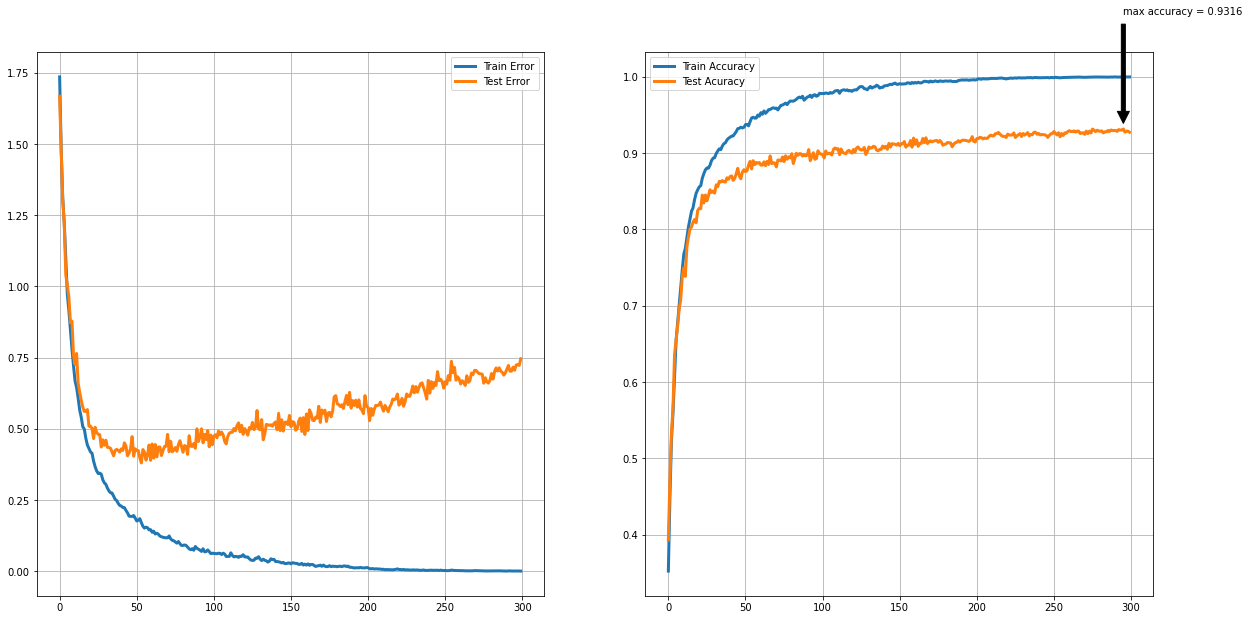

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error')
ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy')
ax2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()
f.savefig("./trainTestCurve.png")